In [2]:
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import cv2

In [5]:
base_dir = '/content/drive/My Drive/PLANT DISEASE RECOGNITION/datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
BATCH_SIZE = 32
IMG_RES = (224, 224)

training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_RES)
validation_set = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_RES)

Found 13471 files belonging to 7 classes.
Found 3367 files belonging to 7 classes.


In [6]:
num_training_examples = 13471
num_classes = 7

In [7]:
train_image_generator = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_image_generator = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [8]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label
IMAGE_RES = 224
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           target_size=(IMAGE_RES,IMAGE_RES), 
                                                           shuffle=True,
                                                           class_mode='sparse')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMAGE_RES,IMAGE_RES), 
                                                              class_mode='sparse')

Found 13471 images belonging to 7 classes.
Found 3367 images belonging to 7 classes.


In [39]:
classes_dict = train_data_gen.class_indices

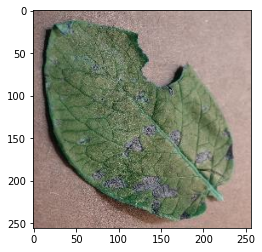

In [42]:
img = train_data_gen.filepaths[np.random.random_integers(low=0, high=train_data_gen.samples)]
img = cv2.imread(img)
plt.imshow(img)

In [43]:
import json
with open('/content/drive/My Drive/PLANT DISEASE RECOGNITION/class_indices.json','w') as f:
  json.dump(classes_dict, f)

In [9]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [10]:
feature_extractor.trainable = False

In [11]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',recall_m,precision_m,f1_m])

EPOCHS = 5

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/5
421/421 [==============================] - 6836s 16s/step - loss: 0.3347 - accuracy: 0.8999 - recall_m: 1.3896 - precision_m: 0.9691 - f1_m: 1.1367 - val_loss: 0.1473 - val_accuracy: 0.9557 - val_recall_m: 1.1175 - val_precision_m: 0.9279 - val_f1_m: 1.0042
Epoch 2/5
421/421 [==============================] - 724s 2s/step - loss: 0.1222 - accuracy: 0.9639 - recall_m: 1.2590 - precision_m: 0.9108 - f1_m: 1.0545 - val_loss: 0.0976 - val_accuracy: 0.9697 - val_recall_m: 1.0762 - val_precision_m: 0.9090 - val_f1_m: 0.9799
Epoch 3/5
421/421 [==============================] - 721s 2s/step - loss: 0.0948 - accuracy: 0.9707 - recall_m: 1.2438 - precision_m: 0.9060 - f1_m: 1.0457 - val_loss: 0.0814 - val_accuracy: 0.9759 - val_recall_m: 1.0820 - val_precision_m: 0.9048 - val_f1_m: 0.9771
Epoch 4/5
421/421 [==============================] - 715s 2s/step - loss: 0.0768 - accuracy: 0.9759 - recall_m: 1.2450 - precision_m: 0.9014 - f1_m: 1.0432 - val_loss: 0.0780 - val_accuracy: 0.9745 - 

<Figure size 432x288 with 0 Axes>

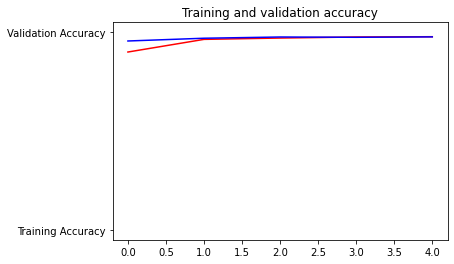

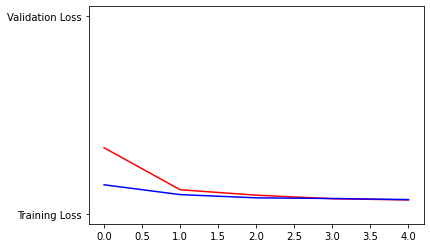

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


In [23]:
cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION'

/content/drive/My Drive/PLANT DISEASE RECOGNITION


In [24]:
model.save('models/mobilenet_model.h5')

In [25]:
import cv2
import PIL
from tensorflow.python import keras
import warnings 
import argparse
warnings.filterwarnings('ignore')
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [27]:
from PIL import Image
np.random.seed(20)
idx = np.random.randint(3)
test_images_dir = os.path.join('datasets/', 'test')
test1 = Image.open(os.path.join(test_images_dir, os.listdir(test_images_dir)[idx]))

Text(0.5, 1.0, 'TomatoYellowCurlVirus3.jpg')

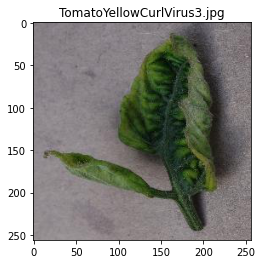

In [28]:
plt.imshow(test1)
plt.title(os.listdir(test_images_dir)[idx])

In [30]:
test1 = test1.resize((224,224))
test1_scaled = np.expand_dims(np.asarray(test1), axis = 0) / 255
predictions = model.predict(test1_scaled)
print(predictions)

[[ -5.180722    -4.3733     -10.851381    -4.8329244   -0.90094686
    5.190582    -6.7415605 ]]


In [44]:
classes_dict = train_data_gen.class_indices
classes_dict = { v:k for (k,v) in classes_dict.items() }
classes_dict[np.argmax(predictions)]

'Tomato___Tomato_Yellow_Leaf_Curl_Virus'